# Summary
In previous experiments I tried to use transformers to solve the downstream problem. None of them was succsessful. It seemed like the network was able to overfit, but it wasn't able to discriminate between the cases. In this notebook I try to explore different options for modeling, in hopes to see some seperation.

# Load

In [3]:
import os
import re
import yaml

# make sure we're in the correct directory
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')

# import trainer
from executors.train_on_local_machine_mps import trainer

import pandas as pd
data = pd.read_csv('./data/combined_data/metadata_balanced_by_death.csv', index_col=0)
data.iloc[:4]

,sample,reading,dates,one_year_until_death,CVA,first_AF_in_home_ECG,first_AF_in_Dispatch,AF,IHD,sp_MI_all,sp_CABG,CHF,sp_CPR,cpr_shl,DM2,AF2,DM
0,train,427094,01/09/2008,1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,train,449383,25/05/2018,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,test,220126,13/10/2003,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,validation,349309,19/12/2006,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
pd.crosstab(data['sample'], data['one_year_until_death'])

one_year_until_death,0,1
sample,,
test,56611,1229
train,259183,259183
validation,52672,1107


#### Inception
It worked so far, but it is  written in `tf`. The code is bellow. Next, we will try to write a similar one in `torch`.

In [6]:
# import pandas as pd
# import numpy as np
# import os
# from tqdm import tqdm
# from sklearn.utils import shuffle
# import random
# import matplotlib.pyplot as plt
# from scipy.signal import resample


# from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
# from sklearn.metrics import f1_score as f1_score_rep
# import seaborn as sn
# from sklearn.metrics import roc_curve, auc
# from itertools import cycle

# from keras.layers import Conv1D, MaxPool1D, Concatenate, BatchNormalization, Activation, Input, Add, \
#                          GlobalAveragePooling1D, Dense
# from keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from livelossplot import PlotLossesKeras
# from tensorflow.keras.metrics import Recall, Precision
# import keras
# import time

# from tensorflow.keras.utils import plot_model


# ---------------- Def Model Class ----------------- #
class Classifier_INCEPTION:
    def __init__(self, weights_directory, input_shape, nb_classes=2, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=10, kernel_size=41, nb_epochs=35):
        self.weights_directory = weights_directory
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                    strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = Conv1D(filters=self.nb_filters, kernel_size=1,
                        padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = Concatenate(axis=2)(conv_list)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                            padding='same', use_bias=False)(input_tensor)
        shortcut_y = BatchNormalization()(shortcut_y)

        x = Add()([shortcut_y, out_tensor])
        x = Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = GlobalAveragePooling1D()(x)

        output_layer = Dense(nb_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', 
                      optimizer=Adam(),
                      metrics=['accuracy', Precision(), Recall(), f1_score])

        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                                      factor=0.5, 
                                      patience=int(self.nb_epochs/20),
                                      min_lr=0.0001)
        
        file_path = os.path.join(self.weights_directory,"best_weights.h5")
        model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                           monitor='val_accuracy',
                                           mode="max",
                                           save_best_only=True)
        
        early_stopping = EarlyStopping(monitor="val_accuracy", 
                                       mode="max", 
                                       verbose=1, 
                                       patience=int(self.nb_epochs/10))
        plotlosses = PlotLossesKeras()
        self.callbacks = [reduce_lr, model_checkpoint, early_stopping, plotlosses]
        return model

    def fit(self, x_train, y_train, x_val, y_val, class_weights=None):       
        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()
        hist = self.model.fit(x_train, y_train, 
                              batch_size=mini_batch_size, 
                              epochs=self.nb_epochs,
                              verbose=self.verbose, 
                              validation_data=(x_val, y_val), 
                              callbacks=self.callbacks)
        
        duration = time.time() - start_time
        keras.backend.clear_session()
        print("Model take {} S to train ".format(duration))
        return hist


ModuleNotFoundError: No module named 'tensorflow'

### Torch Implementation

In [1]:
import os
# make sure we're in the correct directory
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')


In [4]:
from dataloader.DataLoader import *

train_generator = DataGenerator(
    metadata_file_path= './data/combined_data/metadata_balanced_by_death.csv',   # path to metadata file
    data_folder_path = './data/individual-signals/',     # path to individual signals
    sample='train',               # sample we want to create a generator to. Either train, validation or test
    targets=['AF'],             # list of targets we want train on
    batch_size=32,           # batch size
    shuffle=True,       # Whether to shuffle the list of IDs at the end of each epoch.
    fillna=0             )

X,y = train_generator.__getitem__(11)
print(X.shape, y.shape)
X,y


(32, 12, 450) (32, 1, 1)


(array([[[0.08939957, 0.10118657, 0.11202411, ..., 0.08076523,
          0.08547896, 0.09848666],
         [0.11055106, 0.12064912, 0.12912098, ..., 0.07089361,
          0.07769462, 0.09302937],
         [0.92925473, 0.91570575, 0.89776179, ..., 0.89090942,
          0.89239898, 0.88578589],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.09445462, 0.09533713, 0.096144  , ..., 0.09850608,
          0.09961703, 0.10076074],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.14257179, 0.1459219 , 0.14735795, ..., 0.14858546,
          0.14795831, 0.14731995],
         [0.27290008, 0.27455247, 0.2739297 , ..., 0.28716925,
          0.28693609, 0.28670748],
         [0.7453172 , 0.74625989, 0.74717172, ..., 0.73549502,
          0.7450944 , 0.75753045],
         ...,
         [0.35287358, 0.3533134 , 0.35373579, ..., 0.36398143,
          0.363615  , 0.

In [ ]:
X.shape

In [5]:
import torch
from torch import nn
import torch.nn.functional as F


In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_chanels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_chanels, **kwargs)
        self.bn = nn.BatchNorm1d(out_chanels)
        
    def forward(self, x):
        orig_len = x.shape[2]
        unpadded_results = F.relu(self.bn(self.conv(x)))
        unpadded_results_len = unpadded_results.shape[2]
        left_pad,right_pad = int(np.floor((orig_len-unpadded_results_len)/2)) , int(np.ceil((orig_len-unpadded_results_len)/2))

        return F.pad(unpadded_results, (left_pad,right_pad))

class InceptionBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_1,
        red_3,
        out_3,
        red_5,
        out_5,
        out_pool,
    ):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3, kernel_size=1, padding=0),
            ConvBlock(red_3, out_3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5, kernel_size=1),
            ConvBlock(red_5, out_5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )
    
    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)
    

In [7]:
class DownstreamInception(nn.Module):
    def __init__(self, num_classes=1):
        super(DownstreamInception, self).__init__()
        
        self.conv1 = ConvBlock(
            in_channels=12, 
            out_chanels=64,
            kernel_size=7,
            stride=2,
            padding=3,
        )

        self.conv2 = ConvBlock(in_channels=64, 
                               out_chanels=128, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)

        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

                        # in_channels, out_1,red_3,out_3,red_5,out_5,
        self.inception3a = InceptionBlock(128, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 32, 112, 32, 24, 64, 32)
        self.avgpool = nn.AvgPool1d(kernel_size=5, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(8480, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.conv1(X)
        # print('conv1:', out.shape)
        out = self.maxpool(out)
        # print('maxpool:', out.shape)
        out = self.conv2(out)
        # print('conv2:', out.shape)
        out = self.maxpool(out)
        # print('maxpool:', out.shape)
        out = self.inception3a(out)
        # print('inception 3a:', out.shape)
        out = self.inception3b(out)
        # print('inception 3b:', out.shape)
        out = self.maxpool(out)
        # print('maxpool:', out.shape)
        out = self.inception4a(out)
        # print('inception 4a:', out.shape)
        out = self.inception4b(out)
        # print('inception 4b:', out.shape)
        out = self.avgpool(out)
        # print('avgpool:', out.shape)

        out = out.reshape(out.shape[0], -1)
        # print('reshape:', out.shape)
        out = self.dropout(out)
        # print('dropout:', out.shape)
        out = self.fc(out)
        # print('linear:', out.shape)
        out = self.sigmoid(out)

        return out


In [9]:
model = DownstreamInception()
print(model)

# count_parameters(model)

model(X)

DownstreamInception(
  (conv1): ConvBlock(
    (conv): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBlock(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvBlock(
      (conv): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(128, 96, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvBlock(
        (conv): Conv1d(96, 128, kernel_size=(3,), stride=(1

TypeError: conv1d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)


In [56]:
class InceptionV1(nn.Module):
    def __init__(self, num_classes=1):
        super(InceptionV1, self).__init__()
        self.conv1 = ConvBlock(
            in_channels=12, 
            out_chanels=64,
            kernel_size=7,
            stride=2,
            padding=3,
        )
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [10]:
from executors.training_utils import *

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# fix shapes ( -> [length, batch_size, channels])
X = np.float32(X)

X = torch.from_numpy(X)

# Test

In [1]:
config = {
    # general
    'seed': 123,
    'metadata_file_path': './data/combined_data/metadata_balanced_by_death.csv',
    'data_folder_path': './data/individual-signals/',
    'fillna': 0,
    # training
    'batch_size': 32,
    'n_epochs': 30,
    # architecture
    'targets': ['one_year_until_death'],
    'input_dimension': 12,
    'hidden_dimmension':  64 ,          # d_model (int) – the number of expected features in the input (required)???
    'attention_heads': 4 ,            # number of attention heads, if None then d_model//64
    'encoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'positional_encodings': False,
    'saving_path': './models/exp1',
    'model_type': 'Inception'
}

/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




training using device: mps


The model has 651,257 trainable parameters
DownstreamInception(
  (conv1): ConvBlock(
    (conv): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBlock(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): ConvBlock(
      (conv): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(128, 96, kernel_size=(1,), stride=(1,))
        (bn): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (

Within epoch loss (validation) 0.47993: 100%|██████████| 1680/1680 [01:12<00:00, 23.12it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.11436506 0.56273973 0.82929456 0.36365843 0.47387671]
Lengths 53760 53760


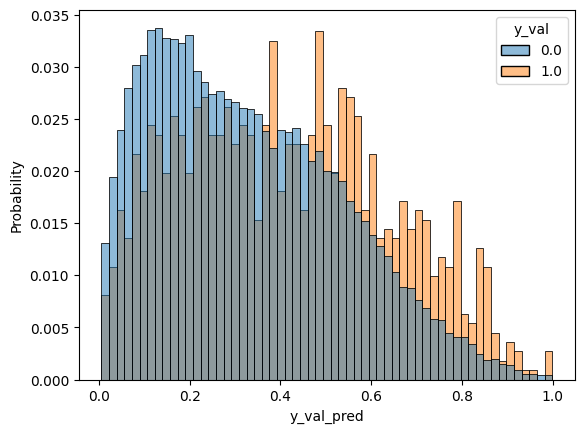

---------------------------------------------
Epoch: 01 | Time: 31m 16s
	Train Loss: 0.647
	 Val. Loss: 0.480
	 Best Val. Loss: 0.480
---------------------------------------------


Within epoch loss (validation) 0.42499: 100%|██████████| 1680/1680 [01:13<00:00, 23.01it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.04803889 0.0507997  0.04343591 0.15106975 0.16886376]
Lengths 53760 53760


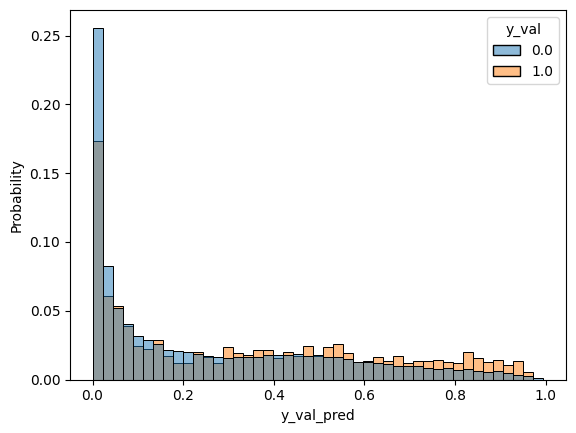

---------------------------------------------
Epoch: 02 | Time: 31m 38s
	Train Loss: 0.508
	 Val. Loss: 0.425
	 Best Val. Loss: 0.425
---------------------------------------------


Within epoch loss (validation) 0.38487: 100%|██████████| 1680/1680 [01:10<00:00, 23.69it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.01268169 0.01969023 0.00492076 0.00681659 0.03162103]
Lengths 53760 53760


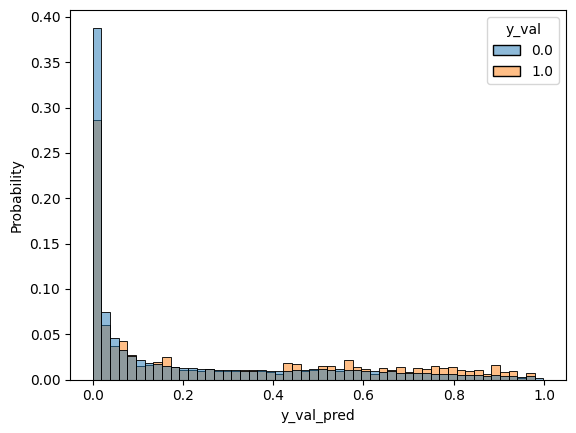

---------------------------------------------
Epoch: 03 | Time: 34m 28s
	Train Loss: 0.405
	 Val. Loss: 0.385
	 Best Val. Loss: 0.385
---------------------------------------------


Within epoch loss (validation) 0.37383: 100%|██████████| 1680/1680 [01:12<00:00, 23.20it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.14367753 0.10730619 0.00181529 0.05730238 0.37614602]
Lengths 53760 53760


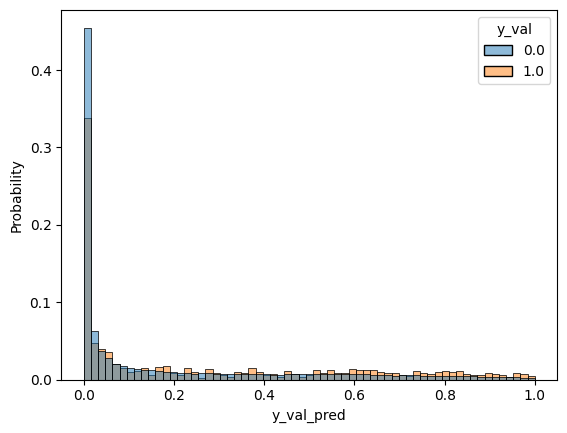

---------------------------------------------
Epoch: 04 | Time: 35m 7s
	Train Loss: 0.342
	 Val. Loss: 0.374
	 Best Val. Loss: 0.374
---------------------------------------------


Within epoch loss (validation) 0.31302: 100%|██████████| 1680/1680 [01:12<00:00, 23.31it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.00561205 0.10073794 0.00906958 0.0147955  0.01536014]
Lengths 53760 53760


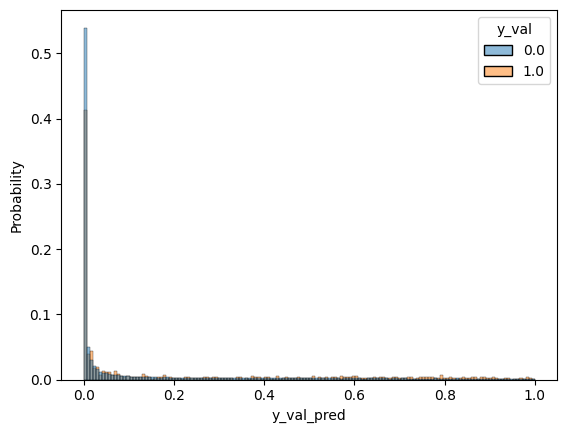

---------------------------------------------
Epoch: 05 | Time: 35m 21s
	Train Loss: 0.304
	 Val. Loss: 0.313
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.36527: 100%|██████████| 1680/1680 [01:10<00:00, 23.82it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [7.92301144e-04 6.89297542e-02 3.46383858e-05 5.03142772e-04
 3.02358642e-02]
Lengths 53760 53760


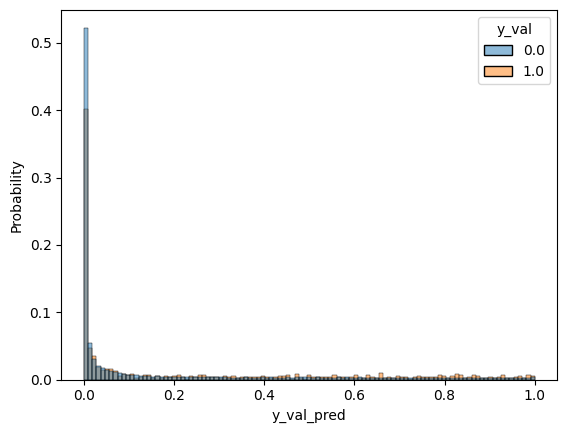

---------------------------------------------
Epoch: 06 | Time: 35m 14s
	Train Loss: 0.277
	 Val. Loss: 0.365
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.37252: 100%|██████████| 1680/1680 [01:11<00:00, 23.35it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [8.78317369e-05 4.07458916e-02 5.62771282e-04 8.74209553e-02
 2.41258770e-01]
Lengths 53760 53760


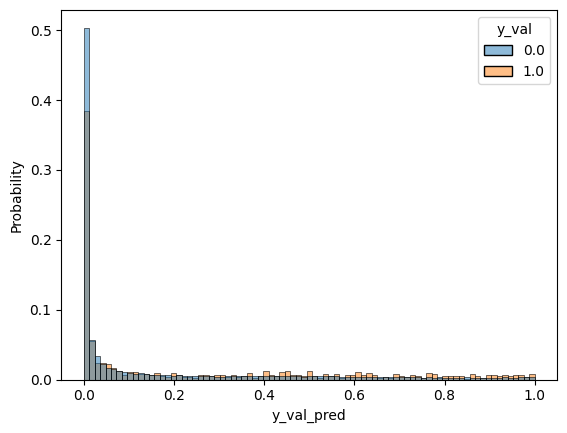

---------------------------------------------
Epoch: 07 | Time: 35m 54s
	Train Loss: 0.258
	 Val. Loss: 0.373
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.3127: 100%|██████████| 1680/1680 [01:10<00:00, 23.70it/s] 


First 5 examples:
[0. 0. 0. 0. 0.] [4.53652901e-05 2.23233685e-04 1.04034483e-03 1.73947356e-05
 2.16176674e-01]
Lengths 53760 53760


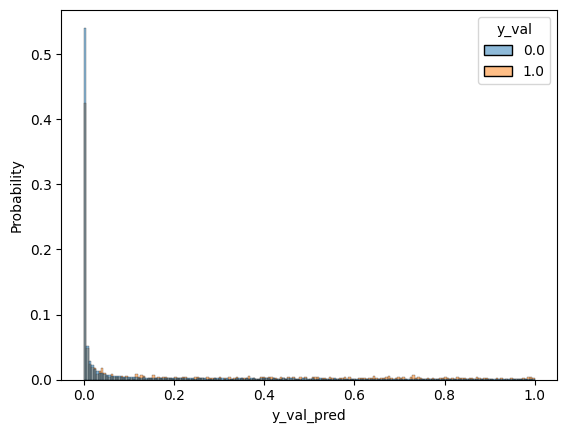

---------------------------------------------
Epoch: 08 | Time: 35m 47s
	Train Loss: 0.241
	 Val. Loss: 0.313
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.32278: 100%|██████████| 1680/1680 [01:11<00:00, 23.34it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [0.00191968 0.00050069 0.00145995 0.00218555 0.00038744]
Lengths 53760 53760


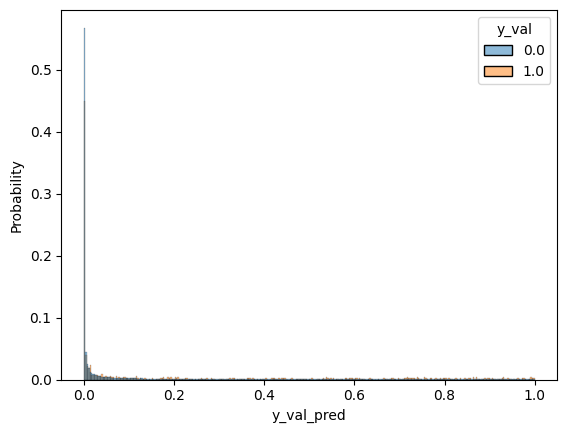

---------------------------------------------
Epoch: 09 | Time: 35m 58s
	Train Loss: 0.229
	 Val. Loss: 0.323
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.33689: 100%|██████████| 1680/1680 [01:12<00:00, 23.32it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [1.09332620e-06 1.91792205e-01 5.09182901e-05 4.89867343e-05
 2.84537762e-01]
Lengths 53760 53760


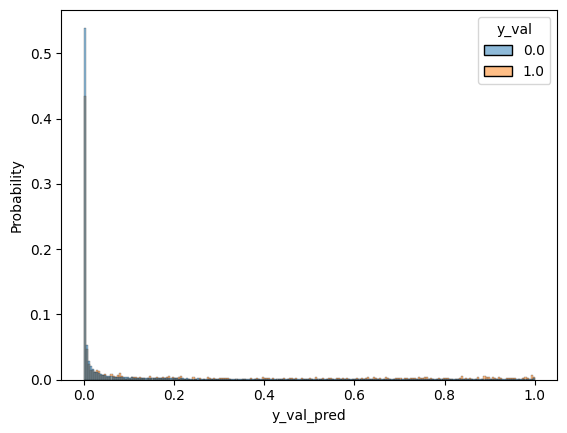

---------------------------------------------
Epoch: 10 | Time: 36m 9s
	Train Loss: 0.219
	 Val. Loss: 0.337
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.35034: 100%|██████████| 1680/1680 [01:10<00:00, 23.66it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [2.05794004e-05 1.29515063e-02 1.64288322e-05 5.27016469e-04
 9.48579609e-02]
Lengths 53760 53760


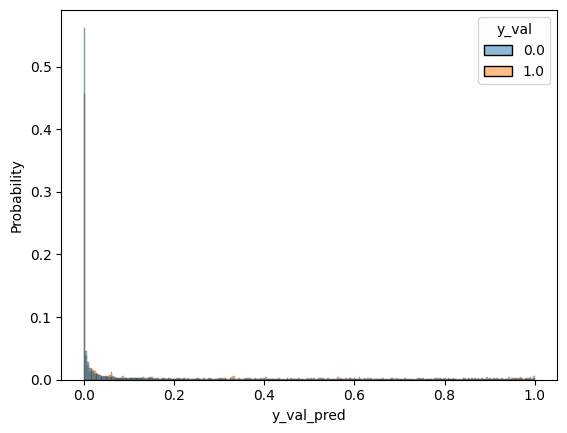

---------------------------------------------
Epoch: 11 | Time: 36m 10s
	Train Loss: 0.210
	 Val. Loss: 0.350
	 Best Val. Loss: 0.313
---------------------------------------------


Within epoch loss (validation) 0.29925: 100%|██████████| 1680/1680 [01:10<00:00, 23.73it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [8.20040645e-04 1.00055605e-03 9.48529318e-03 5.70040647e-05
 1.31910995e-01]
Lengths 53760 53760


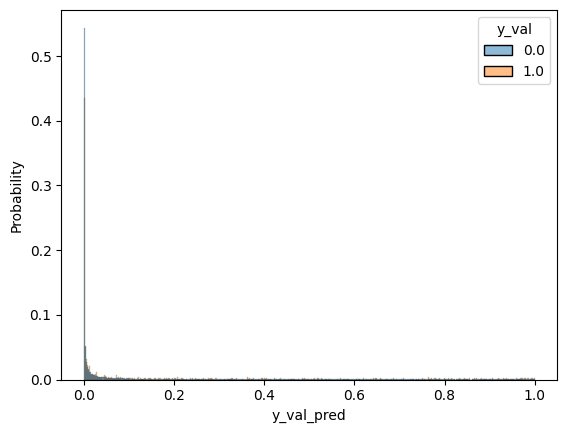

---------------------------------------------
Epoch: 12 | Time: 36m 15s
	Train Loss: 0.203
	 Val. Loss: 0.299
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (validation) 0.30131: 100%|██████████| 1680/1680 [01:10<00:00, 23.78it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [3.23992717e-05 1.49211881e-03 6.65814355e-02 8.17019194e-02
 1.66842639e-01]
Lengths 53760 53760


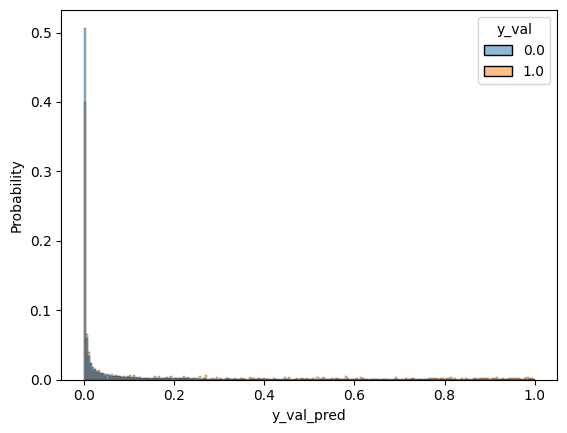

---------------------------------------------
Epoch: 13 | Time: 35m 54s
	Train Loss: 0.197
	 Val. Loss: 0.301
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (validation) 0.30981: 100%|██████████| 1680/1680 [01:11<00:00, 23.37it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [5.26083159e-06 7.74563923e-02 9.06559115e-04 2.04260461e-02
 1.46799050e-02]
Lengths 53760 53760


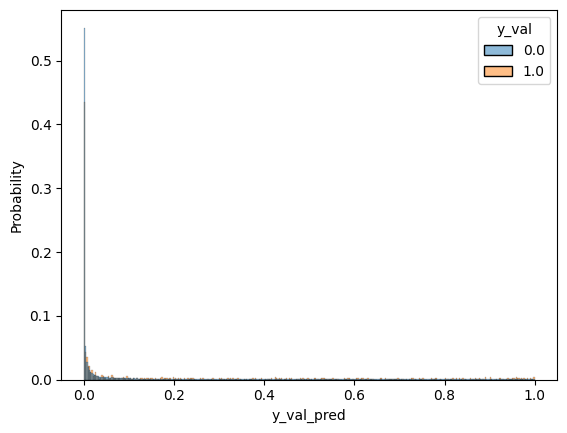

---------------------------------------------
Epoch: 14 | Time: 36m 8s
	Train Loss: 0.191
	 Val. Loss: 0.310
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (validation) 0.33884: 100%|██████████| 1680/1680 [01:14<00:00, 22.59it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [1.31843735e-05 1.44057337e-03 2.16668814e-05 1.86778717e-02
 2.67712343e-02]
Lengths 53760 53760


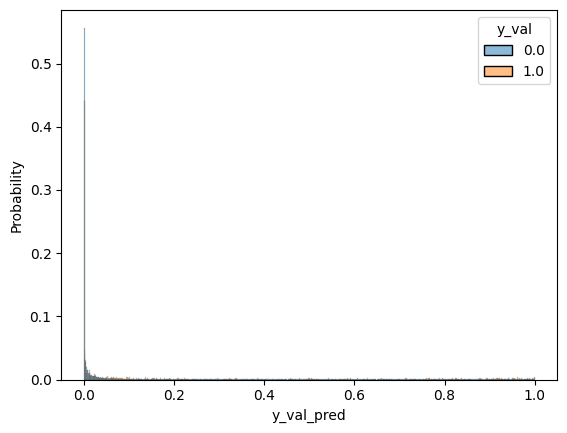

---------------------------------------------
Epoch: 15 | Time: 36m 14s
	Train Loss: 0.186
	 Val. Loss: 0.339
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (validation) 0.32475: 100%|██████████| 1680/1680 [01:15<00:00, 22.21it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [2.28727708e-06 6.45148614e-03 1.08619315e-06 1.42587000e-03
 9.55292642e-01]
Lengths 53760 53760


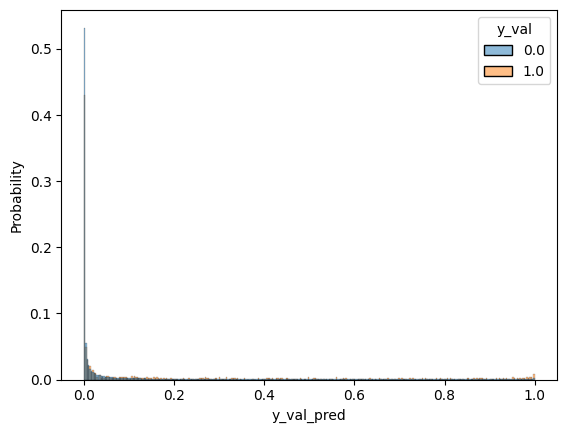

---------------------------------------------
Epoch: 16 | Time: 36m 49s
	Train Loss: 0.182
	 Val. Loss: 0.325
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (validation) 0.32252: 100%|██████████| 1680/1680 [01:13<00:00, 22.79it/s]


First 5 examples:
[0. 0. 0. 0. 0.] [1.55821574e-04 1.28384922e-02 2.83866962e-06 1.23134283e-02
 9.94771123e-02]
Lengths 53760 53760


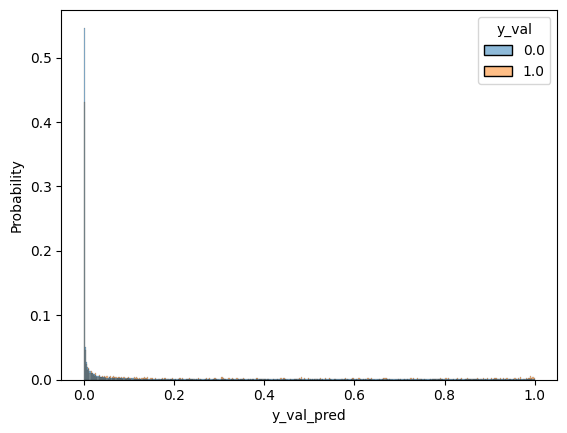

---------------------------------------------
Epoch: 17 | Time: 36m 50s
	Train Loss: 0.177
	 Val. Loss: 0.323
	 Best Val. Loss: 0.299
---------------------------------------------


Within epoch loss (training) 0.17508:  93%|█████████▎| 15019/16198 [32:25<02:32,  7.72it/s]


KeyboardInterrupt: 

In [2]:
import os
# make sure we're in the correct directory
os.chdir('/Users/davidharar/Documents/School/thesis/downstream_classification')
from executors.train_on_local_machine_mps import trainer
trainer(**config)
